# ViT

In [1]:
from pydantic.dataclasses import dataclass
from dataclasses import asdict

import matplotlib.pyplot as plt

import torch
from torch import nn, optim, tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from torchvision import transforms as T
import torchvision.transforms.functional as TF
from functools import partial

import fastcore.all as fc
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset

from miniai.datasets import * 
from miniai.activations import *
from miniai.learner import *
from miniai.conv import * 
from miniai.resnet import *
from miniai.init import * 
from miniai.sgd import *
from miniai.augment import * 

import matplotlib as mpl
import logging; logging.disable(logging.WARNING)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'

In [2]:
set_seed(1)

In [3]:
BaseConfig?

Init signature:
BaseConfig(
    ds: str,
    arch: str,
    project: str,
    epochs: int = 5,
    lr: float = 0.003,
    batch_size: int = 64,
    bias: bool = True,
    model_path: str = 'models',
    save: bool = False,
    max_to_keep: int = 1,
    attn_dropout: float = 0.0,
    dropout: float = 0.01,
) -> None
Docstring:      BaseConfig(ds: str, arch: str, project: str, epochs: int = 5, lr: float = 0.003, batch_size: int = 64, bias: bool = True, model_path: str = 'models', save: bool = False, max_to_keep: int = 1, attn_dropout: float = 0.0, dropout: float = 0.01)
File:           ~/code/fastai2022p2/miniai/init.py
Type:           type
Subclasses:     

In [4]:
@dataclass
class Config(BaseConfig):
    n_channels: int = 1
    img_height: int = 28
    img_width: int = 28  
    patch_size: int = 4
    
    n_embedding: int = 512
    n_heads: int = 16    
    n_layers: int = 12
    n_classes: int = -1
    fanout = 4

In [5]:
conf = Config(ds='fashion_mnist', arch='ViT', project='ViT', batch_size=256, lr=5e-4)
asdict(conf)

{'ds': 'fashion_mnist',
 'arch': 'ViT',
 'project': 'ViT',
 'epochs': 5,
 'lr': 0.0005,
 'batch_size': 256,
 'bias': True,
 'model_path': 'models',
 'save': False,
 'max_to_keep': 1,
 'attn_dropout': 0.0,
 'dropout': 0.01,
 'n_channels': 1,
 'img_height': 28,
 'img_width': 28,
 'patch_size': 4,
 'n_embedding': 512,
 'n_heads': 16,
 'n_layers': 12,
 'n_classes': -1}

# Data

In [6]:
dsd = load_dataset(conf.ds)

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [8]:
ds_train = dsd['train']

In [9]:
xl, yl = 'image', 'label'

In [10]:
conf.n_classes =  dsd['train'].features[yl].num_classes
print("Num classes: ", conf.n_classes)

Num classes:  10


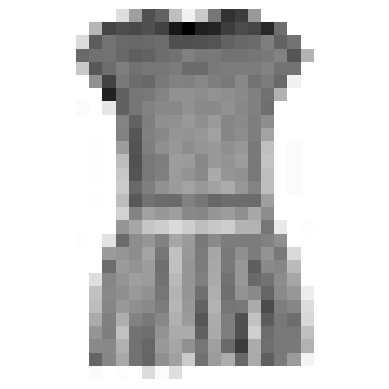

In [11]:
xform = T.Compose([T.Resize((conf.img_height, conf.img_width), antialias=True), T.ToTensor()])

plt.imshow(xform(dsd['train'][3][xl]).permute(1, 2, 0))
plt.axis('off');

In [12]:
def transform(b):
    b[xl] = [xform(o) for o in b[xl]]
    return b

In [13]:
tds = dsd.with_transform(transform)

In [14]:
dls = DataLoaders.from_dd(tds, conf.batch_size)

In [15]:
xb, yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

# Model

In [16]:
class PatchEmbedding(nn.Module):
    def __init__(self, height, width, patch_size, n_channels, n_embedding):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=n_channels, out_channels=n_embedding,
                              kernel_size=patch_size, stride=patch_size)
                
    def forward(self, x):
        x = self.conv(x) # (B, n_embedding, patch_size, patch_size)
        B, N, *_ = x.shape
        return x.view(B, N, -1).permute(0, 2, 1) # (B, 16*16, n_embedding)
        

In [17]:
class Block(nn.Module):
    def __init__(self, n_embedding, n_heads, fanout, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embedding)
        self.attention = nn.MultiheadAttention(n_embedding, n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(n_embedding)
        self.mlp = nn.Sequential(
            nn.Linear(n_embedding, fanout*n_embedding),
            conf.act(),
            nn.Dropout(p=dropout),
            nn.Linear(fanout*n_embedding, n_embedding),
            nn.Dropout(p=dropout))

    def forward(self, x):
        z = self.ln1(x)
        x1, _ = self.attention(query=z, key=z, value=z)
        x1 += x
        return x1 + self.mlp(self.ln2(x1))        

In [18]:
class ViT(nn.Module):
    def __init__(self, conf: Config):
        super().__init__()
        self.N = conf.img_height * conf.img_width // (conf.patch_size**2)
        self.conf = conf
        self.patcher = PatchEmbedding(conf.img_height, conf.img_width, conf.patch_size, conf.n_channels, conf.n_embedding)
        self.position_embedding = nn.Embedding(self.N, conf.n_embedding)
        self.blocks = nn.Sequential(*[Block(conf.n_embedding, conf.n_heads, conf.fanout, conf.attn_dropout) for _ in range(conf.n_layers)])
        self.ln = nn.LayerNorm(conf.n_embedding * self.N)
        self.classification_head = nn.Linear(conf.n_embedding * self.N, conf.n_classes)
        
        self.apply(self._init_weights)
        
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.kaiming_normal_(module.weight, a=self.conf.leak)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0., std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)    
    
    def forward(self, x):
        B, *_ = x.shape
        x = self.patcher(x)
        #x = torch.cat((self.class_token.expand(B, -1, -1), x), dim=1)
        x += self.position_embedding(torch.arange(self.N, device=device))
        x = self.blocks(x)
        x = self.classification_head(self.ln(x.view(B, -1))) 
        return x

# Training Loop

In [19]:
model = ViT(conf).to(device)
tmax = conf.epochs * len(dls.train)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
sched = BatchSchedCB(partial(optim.lr_scheduler.OneCycleLR, max_lr=conf.lr, total_steps=tmax))
wand = WandBCB(conf)
cbs = [metrics, sched, wand, ProgressCB(plot=True)]
learn = Learner(model, dls, loss_func=F.cross_entropy, cbs=[DeviceCB(device=device)], opt_func=partial(optim.AdamW, betas=conf.betas))

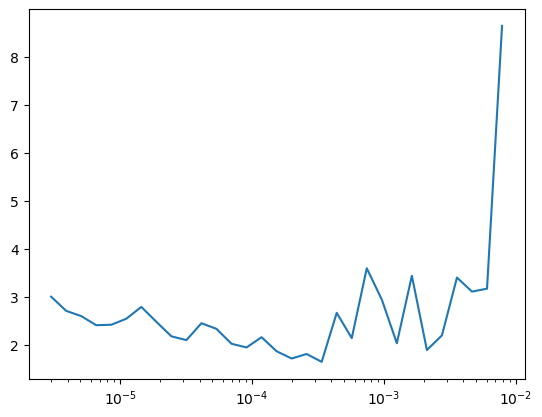

In [26]:
learn.lr_find(start_lr=3e-6)  #5e-4

## Model Summary

In [19]:
from torchinfo import summary

xb, yb = next(iter(dls.train))
xb.shape

torch.Size([256, 1, 28, 28])

In [20]:
summary(model, input_data=xb.to(device))

Layer (type:depth-idx)                   Output Shape              Param #
ViT                                      [256, 10]                 --
├─PatchEmbedding: 1-1                    [256, 49, 512]            --
│    └─Conv2d: 2-1                       [256, 512, 7, 7]          8,704
├─Embedding: 1-2                         [49, 512]                 25,088
├─Sequential: 1-3                        [256, 49, 512]            --
│    └─Block: 2-2                        [256, 49, 512]            --
│    │    └─LayerNorm: 3-1               [256, 49, 512]            1,024
│    │    └─MultiheadAttention: 3-2      [256, 49, 512]            1,050,624
│    │    └─LayerNorm: 3-3               [256, 49, 512]            1,024
│    │    └─Sequential: 3-4              [256, 49, 512]            2,099,712
│    └─Block: 2-3                        [256, 49, 512]            --
│    │    └─LayerNorm: 3-5               [256, 49, 512]            1,024
│    │    └─MultiheadAttention: 3-6      [256, 49, 512]

## Training

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leourbina. Use `wandb login --relogin` to force relogin


accuracy,loss,epoch,train
0.705,0.850,0,train
0.794,0.605,0,valid
0.834,0.475,1,train
0.856,0.404,1,valid
0.863,0.378,2,train
0.872,0.360,2,valid
0.891,0.301,3,train
0.890,0.313,3,valid
0.910,0.249,4,train
0.897,0.291,4,valid


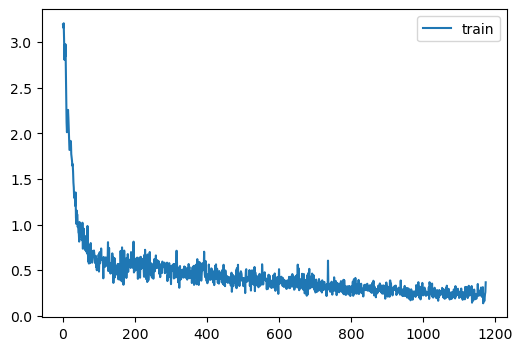

In [21]:
learn.fit(conf.epochs, cbs=cbs)

# Data Augmentation

In [20]:
from torchvision import transforms

In [21]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop):
    return tfmx(b[0]), tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4, ))

In [22]:
xb, yb = next(iter(dls.train))

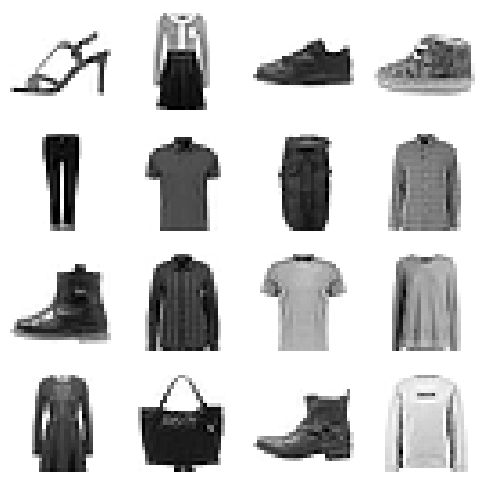

In [23]:
txb = tfms(xb)
show_images(txb[:16], imsize=1.5)